# Vector-space models: designs, distances, basic reweighting

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Motivation](#Motivation)
1. [Terminological notes](#Terminological-notes)
1. [Set-up](#Set-up)
1. [Matrix designs](#Matrix-designs)
1. [Pre-computed example matrices](#Pre-computed-example-matrices)
1. [Vector comparison](#Vector-comparison)
  1. [Euclidean](#Euclidean)
  1. [Length normalization](#Length-normalization)
  1. [Cosine distance](#Cosine-distance)
  1. [Matching-based methods](#Matching-based-methods)
  1. [Summary](#Summary)
1. [Distributional neighbors](#Distributional-neighbors)
1. [Matrix reweighting](#Matrix-reweighting)
  1. [Normalization](#Normalization)
  1. [Observed/Expected](#Observed/Expected)
  1. [Pointwise Mutual Information](#Pointwise-Mutual-Information)
  1. [TF-IDF](#TF-IDF)
1. [Subword information](#Subword-information)
1. [Visualization](#Visualization)
1. [Exploratory exercises](#Exploratory-exercises)

## Overview

This notebook is the first in our series about creating effective __distributed representations__. The focus is on matrix designs, assessing similarity, and methods for matrix reweighting.

The central idea (which takes some getting used to!) is that we can represent words and phrases as dense vectors of real numbers. These take on meaning by being __embedded__ in a larger matrix of representations with comparable structure.

## Motivation

Why build distributed representations? There are potentially many reasons. The two we will emphasize in this course:

1. __Understanding words in context__: There is value to linguists in seeing what these data-rich approaches can teach use about natural language lexicons, and there is value for social scientists in understanding how words are being used.

1. __Feature representations for other models__: As we will see, many models can benefit from representing examples as distributed representations.

## Terminological notes

* The distributed representations we build will always be vectors of real numbers. The models are often called __vector space models__ (VSMs).

* __Distributional representations__ are the special case where the data come entirely from co-occurrence counts in corpora. 

* We'll look at models that use supervised labels to obtain vector-based word representations. These aren't purely distributional, in that they take advantage of more than just co-occurrence patterns among items in the vocabulary, but they share the idea that words can be modeled with vectors.

* If a neural network is used to train the representations, then they might be called __neural representations__.

* The term __word embedding__ is also used for distributed representations, including distributional ones. This term is a reminder that vector representations are meaningful only when embedded in and compared with others in a unified space (usually a matrix) of representations of the same type.

* In any case, __distributed representation__ seems like the most general cover term for what we're trying to achieve, and its only downside is that sometimes people think it has something to do with distributed databases.

## Set-up

* Make sure your environment meets all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u/). For help getting set-up, see [setup.ipynb](setup.ipynb]).

* Download [the course data](http://web.stanford.edu/class/cs224u/data/data.zip), unpack it, and place it in the directory containing the course repository – the same directory as this notebook. (If you want to put it somewhere else, change `DATA_HOME` below.)

In [436]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import vsm
import matplotlib.pyplot as plt

In [3]:
DATA_HOME = os.path.join('data', 'vsmdata')

## Matrix designs

There are many, many ways to define distributional matrices. Here's a schematic overview that highlights the major decisions for building a word $\times$ word matrix:

1. Define a notion of __co-occurrence context__. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.

1. Define a __count scaling method__. The simplest method just counts everything in the context window, giving equal weight to everything inside it. A common alternative is to scale the weights based on proximity to the target word – e.g., $1/d$, where $d$ is the distance in tokens from the target.

1. Scan through your corpus building a dictionary $d$ mapping word-pairs to co-occurrence values. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1), increment $d[(w, w')]$ by whatever value is determined by your weighting scheme. You'd increment by $1$ with the weighting scheme that simply counts co-occurrences.

1. Using the count dictionary $d$ that you collected in 3, establish your full vocabulary $V$, an ordered list of words types. 
    1. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. 
    1. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. 
    1. You might impose a minimum count threshold even if $|V|$ is small — for words with very low counts, you simply don't have enough evidence to support good representations.
    1. For words outside the vocabulary you choose, you could ignore them entirely or accumulate all their values into a designated _UNK_ vector.

1. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the value $d[(w_{1}, w_{j})]$.

## Pre-computed example matrices

The data distribution includes four matrices that we'll use for hands-on exploration. All of them were designed in the same basic way:

* They are word $\times$ word matrices with 5K rows and 5K columns. 

* The vocabulary is the top 5K most frequent unigrams.

Two come from IMDB user-supplied movie reviews, and two come from Gigaword, a collection of newswire and newspaper text. Further details:

|filename | source | window size| count weighting |
|---------|--------|------------|-----------------|
|imdb_window5-scaled.csv.gz | IMDB movie reviews | 5| 1/d |
|imdb_window20-flat.csv.gz | IMDB movie reviews | 20| 1 |
|gigaword_window5-scaled.csv.gz | Gigaword | 5 | 1/d |
|gigaword_window20-flat.csv.gz | Gigaword | 20 | 1 |

Any hunches about how these matrices might differ from each other?

In [4]:
imdb5 = pd.read_csv(
    os.path.join(DATA_HOME, 'imdb_window5-scaled.csv.gz'), index_col=0)

In [5]:
imdb20 = pd.read_csv(
    os.path.join(DATA_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)

In [6]:
giga5 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window5-scaled.csv.gz'), index_col=0)

In [7]:
giga20 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

In [53]:
# It's a square matrix mirrored across the diagonal
L = len(imdb20)
for i in range(L - 1):
    j = L - 1 - i
    assert imdb20.iloc[i, j] == imdb20.iloc[j, i]

In [83]:
_words = ['gross', 'horrible', 'bad', 'ok', 'fine', 'good', 'amazing']
words = imdb20.loc[_words, _words]
words

,gross,horrible,bad,ok,fine,good,amazing
gross,12880.0,98.0,479.0,75.0,85.0,992.0,70.0
horrible,98.0,67397.0,6492.0,577.0,261.0,5594.0,400.0
bad,479.0,6492.0,592460.0,5071.0,2707.0,98231.0,2742.0
ok,75.0,577.0,5071.0,82004.0,892.0,11081.0,504.0
fine,85.0,261.0,2707.0,892.0,101607.0,11170.0,664.0
good,992.0,5594.0,98231.0,11081.0,11170.0,1425940.0,11158.0
amazing,70.0,400.0,2742.0,504.0,664.0,11158.0,136659.0


In [84]:
words / words.max()

,gross,horrible,bad,ok,fine,good,amazing
gross,1.000000,0.001454,0.000808,0.000915,0.000837,0.000696,0.000512
horrible,0.007609,1.000000,0.010958,0.007036,0.002569,0.003923,0.002927
bad,0.037189,0.096325,1.000000,0.061838,0.026642,0.068889,0.020065
ok,0.005823,0.008561,0.008559,1.000000,0.008779,0.007771,0.003688
fine,0.006599,0.003873,0.004569,0.010878,1.000000,0.007833,0.004859
good,0.077019,0.083001,0.165802,0.135128,0.109933,1.000000,0.081648
amazing,0.005435,0.005935,0.004628,0.006146,0.006535,0.007825,1.000000


## Vector comparison

Vector comparisons form the heart of our analyses in this context. 

* For the most part, we are interested in measuring the __distance__ between vectors. The guiding idea is that semantically related words should be close together in the vector spaces we build, and semantically unrelated words should be far apart.

* The [scipy.spatial.distance](http://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html) module has a lot of vector comparison methods, so you might check them out if you want to go beyond the functions defined and explored here. Read the documentation closely, though: many of those methods are defined only for binary vectors, whereas the VSMs we'll use allow all float values.

### Euclidean

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is

$$\textbf{euclidean}(u, v) = 
\sqrt{\sum_{i=1}^{n}|u_{i} - v_{i}|^{2}}$$

In two-dimensions, this corresponds to the length of the most direct line between the two points.

In `vsm.py`, the function `euclidean` just uses the corresponding [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) method to define it.

Here's the tiny vector space from the screencast on vector comparisons associated with this notebook:

In [86]:
ABC = pd.DataFrame([
    [ 2.0,  4.0], 
    [10.0, 15.0], 
    [14.0, 10.0]],
    index=['A', 'B', 'C'],
    columns=['x', 'y'])    

In [87]:
ABC

,x,y
A,2.0,4.0
B,10.0,15.0
C,14.0,10.0


In [88]:
def plot_ABC(df):
    ax = df.plot.scatter(x='x', y='y', marker='.', legend=False)
    m = df.values.max(axis=None)
    ax.set_xlim([0, m*1.2])
    ax.set_ylim([0, m*1.2])
    for label, row in df.iterrows():
        ax.text(row['x'], row['y'], label)

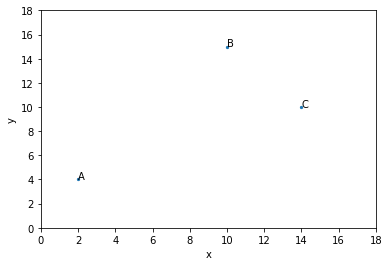

In [11]:
plot_ABC(ABC)

The euclidean distances align well with raw visual distance in the plot:

In [89]:
def abc_comparisons(df, distfunc):
    for a, b in (('A', 'B'), ('B', 'C')):
        dist = distfunc(df.loc[a], df.loc[b])
        print('{0:}({1:}, {2:}) = {3:7.02f}'.format(
            distfunc.__name__, a, b, dist))

In [90]:
abc_comparisons(ABC, vsm.euclidean)

euclidean(A, B) =   13.60
euclidean(B, C) =    6.40


However, suppose we think of the vectors as word meanings in the vector-space sense. In that case, the values don't look good: 

* The distributions of B and C are more or less directly opposed, suggesting very different meanings, whereas A and B are rather closely aligned, abstracting away from the fact that the first is far less frequent than the second. 

* In terms of the large models we will soon explore, A and B resemble a pair like _superb_ and _good_, which have similar meanings but very different frequencies. 

* In contrast, B and C are like _good_ and _disappointing_ — similar overall frequencies but different distributions with respect to the overall vocabulary.

### Length normalization

These affinities are immediately apparent if we __normalize the vectors by their length__. To do this, we first define the L2-length of a vector:

$$\|u\|_{2} = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$

And then the normalization step just divides each value by this quantity:

$$\left[ 
  \frac{u_{1}}{\|u\|_{2}}, 
  \frac{u_{2}}{\|u\|_{2}}, 
  \ldots 
  \frac{u_{n}}{\|u\|_{2}} 
 \right]$$

In [91]:
ABC_normed = ABC.apply(vsm.length_norm, axis=1)

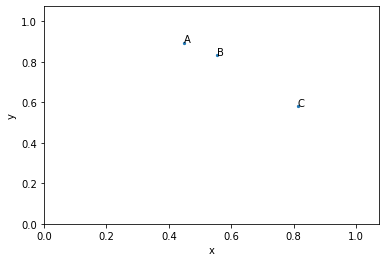

In [92]:
plot_ABC(ABC_normed)    

In [94]:
abc_comparisons(ABC_normed, vsm.euclidean)

euclidean(A, B) =    0.12
euclidean(B, C) =    0.36


Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

Cosine distance takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is

$$\textbf{cosine}(u, v) = 
1 - \frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|_{2} \cdot \|v\|_{2}}$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the angles between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using $\|\cdot\|_{2}$ and then calculating their Euclidean distance.

In [95]:
abc_comparisons(ABC, vsm.cosine)

cosine(A, B) =    0.01
cosine(B, C) =    0.07


So, in building in the length normalization, cosine distance achieves our goal of associating A and B and separating both from C.

### Matching-based methods

Matching-based methods are also common in the literature. The basic matching measure effectively creates a vector consisting of all of the smaller of the two values at each coordinate, and then sums them:

$$\textbf{matching}(u, v) = \sum_{i=1}^{n} \min(u_{i}, v_{i})$$

This is implemented in `vsm` as `matching`.

One approach to normalizing the matching values is the [__Jaccard coefficient__](https://en.wikipedia.org/wiki/Jaccard_index). The numerator is the matching coefficient. The denominator — the normalizer — is intuitively like the set union: for binary vectors, it gives the cardinality of the union of the two being compared:

$$\textbf{jaccard}(u, v) = 
1 - \frac{\textbf{matching}(u, v)}{\sum_{i=1}^{n} \max(u_{i}, v_{i})}$$

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [96]:
for m in (vsm.euclidean, vsm.cosine, vsm.jaccard):
    fmt = {
        'n': m.__name__,  
        'AB': m(ABC.loc['A'], ABC.loc['B']), 
        'BC': m(ABC.loc['B'], ABC.loc['C'])}
    print('{n:>15}(A, B) = {AB:5.2f} {n:>15}(B, C) = {BC:5.2f}'.format(**fmt))

      euclidean(A, B) = 13.60       euclidean(B, C) =  6.40
         cosine(A, B) =  0.01          cosine(B, C) =  0.07
        jaccard(A, B) =  0.76         jaccard(B, C) =  0.31


## Distributional neighbors

The `neighbors` function in `vsm` is an investigative aide. For a given word `w`, it ranks all the words in the vocabulary according to their distance from `w`, as measured by `distfunc` (default: `vsm.cosine`).

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example uses; you might try some new words to get a feel for what these matrices are like and how different words look.

In [103]:
vsm.neighbors('A', ABC, distfunc=vsm.euclidean)

A     0.000000
C    13.416408
B    13.601471
dtype: float64

In [104]:
vsm.neighbors('A', ABC, distfunc=vsm.cosine)

A    0.000000
B    0.007722
C    0.116212
dtype: float64

In [105]:
vsm.neighbors('good', imdb5, distfunc=vsm.euclidean).head()

good      0.000000e+00
job       1.191396e+06
pretty    1.192212e+06
e         1.194603e+06
guys      1.194643e+06
dtype: float64

In [106]:
vsm.neighbors('good', imdb20, distfunc=vsm.euclidean).head()

good      0.000000e+00
really    1.709370e+06
great     1.746426e+06
well      1.757869e+06
story     1.760839e+06
dtype: float64

In [107]:
vsm.neighbors('good', imdb5, distfunc=vsm.cosine).head()

good       0.000000
measure    0.819398
.          0.843800
luck       0.863481
pretty     0.868561
dtype: float64

In [110]:
vsm.neighbors('good', imdb20, distfunc=vsm.cosine).head()

good       0.000000
.          0.133102
pretty     0.183657
acting     0.185801
measure    0.192544
dtype: float64

In [111]:
vsm.neighbors('good', giga20, distfunc=vsm.cosine).head()

good      0.000000
.         0.102634
</p>      0.127549
<p>       0.130171
pretty    0.130454
dtype: float64

## Matrix reweighting

* The goal of reweighting is to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. 

* Absent a defined objective function, this will remain fuzzy, but the intuition behind moving away from raw counts is that frequency is a poor proxy for our target semantic ideas.

### Normalization

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With `vsm.length_norm`, we normalize using `vsm.vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

$$\left[ 
  \frac{u_{1}}{\sum_{i=1}^{n}u_{i}}, 
  \frac{u_{2}}{\sum_{i=1}^{n}u_{i}}, 
  \ldots
  \frac{u_{n}}{\sum_{i=1}^{n}u_{i}}, 
\right]$$

These normalization measures are __insensitive to the magnitude of the underlying counts__. This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different vectors in ways that will be partly or totally obscured by normalization.

In [160]:
words

,gross,horrible,bad,ok,fine,good,amazing
gross,12880.0,98.0,479.0,75.0,85.0,992.0,70.0
horrible,98.0,67397.0,6492.0,577.0,261.0,5594.0,400.0
bad,479.0,6492.0,592460.0,5071.0,2707.0,98231.0,2742.0
ok,75.0,577.0,5071.0,82004.0,892.0,11081.0,504.0
fine,85.0,261.0,2707.0,892.0,101607.0,11170.0,664.0
good,992.0,5594.0,98231.0,11081.0,11170.0,1425940.0,11158.0
amazing,70.0,400.0,2742.0,504.0,664.0,11158.0,136659.0


In [148]:
np.clip(words / (words.sum() - words.max()), a_min=0, a_max=1)

,gross,horrible,bad,ok,fine,good,amazing
gross,1.000000,0.007301,0.004139,0.004121,0.005387,0.007177,0.004505
horrible,0.054475,1.000000,0.056100,0.031703,0.016541,0.040470,0.025743
bad,0.266259,0.483684,1.000000,0.278626,0.171557,0.710655,0.176471
ok,0.041690,0.042989,0.043821,1.000000,0.056531,0.080166,0.032437
fine,0.047248,0.019446,0.023392,0.049011,1.000000,0.080810,0.042734
good,0.551417,0.416778,0.848853,0.608846,0.707903,1.000000,0.718110
amazing,0.038911,0.029802,0.023695,0.027692,0.042081,0.080723,1.000000


In [155]:
numerator = words / words.sum().sum()
denominator = (words / words.sum()) * (words.T / words.T.sum())
(numerator / denominator)

,gross,horrible,bad,ok,fine,good,amazing
gross,0.006111,24.345889,382.453841,48.902789,59.215916,900.904557,120.875676
horrible,0.803141,0.035401,28.218637,6.356515,19.284877,159.759979,21.153243
bad,0.164317,0.367513,0.309211,0.723271,1.859384,9.097915,3.085812
ok,1.049437,4.135004,36.126088,0.044726,5.642772,80.651324,16.788288
fine,0.925974,9.141368,67.674692,4.111782,0.049537,80.008713,12.742918
good,0.079343,0.426510,1.864945,0.330991,0.450614,0.626743,0.758317
amazing,1.124397,5.964743,66.810864,7.277201,7.580351,80.094759,0.061915


In [176]:
joint = words / words.sum().sum()
joint

,gross,horrible,bad,ok,fine,good,amazing
gross,0.004705,0.000036,0.000175,0.000027,0.000031,0.000362,0.000026
horrible,0.000036,0.024619,0.002371,0.000211,0.000095,0.002043,0.000146
bad,0.000175,0.002371,0.216413,0.001852,0.000989,0.035882,0.001002
ok,0.000027,0.000211,0.001852,0.029954,0.000326,0.004048,0.000184
fine,0.000031,0.000095,0.000989,0.000326,0.037115,0.004080,0.000243
good,0.000362,0.002043,0.035882,0.004048,0.004080,0.520866,0.004076
amazing,0.000026,0.000146,0.001002,0.000184,0.000243,0.004076,0.049919


In [179]:
marginal = joint.sum()
marginal

gross       0.005362
horrible    0.029521
bad         0.258684
ok          0.036602
fine        0.042879
good        0.571357
amazing     0.055594
dtype: float64

In [226]:
w1 = 'amazing'
w2 = 'bad'
print(f'## {w1}, {w2} ##')
observed = joint.loc[w1, w2]
print('Observed:', observed)
expected = marginal.loc[w1] * marginal.loc[w2]
print(f'Marginal "{w1}":', marginal.loc[w1])
print(f'Marginal "{w2}":', marginal.loc[w2])
print('Expected:', expected)
ooe = observed / expected
print('OOE:', ooe)
pmi = np.log(ooe)
print('PMI:', pmi)


## amazing, bad ##
Observed: 0.001001595173640879
Marginal "amazing": 0.05559437660197696
Marginal "bad": 0.2586840529756911
Expected: 0.014381378662056328
OOE: 0.06964528208157654
PMI: -2.664340318572844


In [225]:
vsm.observed_over_expected(words)

,gross,horrible,bad,ok,fine,good,amazing
gross,163.643270,0.226147,0.126145,0.139590,0.135046,0.118279,0.085777
horrible,0.226147,28.248074,0.310524,0.195053,0.075316,0.121144,0.089026
bad,0.126145,0.310524,3.234033,0.195632,0.089146,0.242771,0.069645
ok,0.139590,0.195053,0.195632,22.358370,0.207605,0.193547,0.090472
fine,0.135046,0.075316,0.089146,0.207605,20.186743,0.166544,0.101747
good,0.118279,0.121144,0.242771,0.193547,0.166544,1.595551,0.128314
amazing,0.085777,0.089026,0.069645,0.090472,0.101747,0.128314,16.151069


### Observed/Expected

Reweighting by observed-over-expected values captures one of the central patterns in all of VSMs: we can adjust the actual cell value in a co-occurrence matrix using information from the corresponding row and column. 

In the case of observed-over-expected, the rows and columns define our expectation about what the cell value would be if the two co-occurring words were independent. In dividing the observed count by this value, we amplify cells whose values are larger than we would expect.

So that this doesn't look more complex than it is, for an $m \times n$ matrix $X$, define

$$\textbf{rowsum}(X, i) = \sum_{j=1}^{n}X_{ij}$$

$$\textbf{colsum}(X, j) = \sum_{i=1}^{m}X_{ij}$$

$$\textbf{sum}(X) = \sum_{i=1}^{m}\sum_{j=1}^{n} X_{ij}$$

$$\textbf{expected}(X, i, j) = 
\frac{
  \textbf{rowsum}(X, i) \cdot \textbf{colsum}(X, j)
}{
  \textbf{sum}(X)
}$$


Then the observed-over-expected value is

$$\textbf{oe}(X, i, j) = \frac{X_{ij}}{\textbf{expected}(X, i, j)}$$

In many contexts, it is more intuitive to first normalize the count matrix into a joint probability table and then think of $\textbf{rowsum}$ and $\textbf{colsum}$ as probabilities. Then it is clear that we are comparing the observed joint probability with what we would expect it to be under a null hypothesis of independence. These normalizations do not affect the final results, though.

Let's do a quick worked-out example. Suppose we have the count matrix $X$ = 

|          | a  | b  | rowsum |
|----------|----|----|-------|
| __x__    | 34 | 11 |  45   |
| __y__    | 47 | 7  |  54   |
|__colsum__| 81 | 18 |  99   |

Then we calculate like this:

$$\textbf{oe}(X, 1, 0) = \frac{47}{\frac{54 \cdot 81}{99}} = 1.06$$

And the full table looks like this:

|        | a    | b    | 
|--------|------|------|
| __x__  | 0.92 | 1.34 | 
| __y__  | 1.06 | 0.71 |

In [224]:
oe_ex = np.array([[ 34.,  11.], [ 47.,   7.]])

vsm.observed_over_expected(oe_ex).round(2)

array([[0.92, 1.34],
       [1.06, 0.71]])

The implementation `vsm.observed_over_expected` should be pretty efficient.

In [227]:
vsm.observed_over_expected??

In [228]:
imdb5_oe = vsm.observed_over_expected(imdb5)

In [229]:
imdb20_oe = vsm.observed_over_expected(imdb20)

In [230]:
vsm.neighbors('good', imdb5_oe).head()

good       0.000000
.          0.716910
movie      0.791847
film       0.825658
measure    0.852617
dtype: float64

In [231]:
vsm.neighbors('good', imdb20_oe).head()

good     0.000000
.        0.081301
movie    0.083552
br       0.086846
film     0.102811
dtype: float64

### Pointwise Mutual Information

Pointwise Mutual Information (PMI) is observed-over-expected in log-space:

$$\textbf{pmi}(X, i, j) = \log\left(\frac{X_{ij}}{\textbf{expected}(X, i, j)}\right)$$

This basic definition runs into a problem for $0$ count cells. The usual response is to set $\log(0) = 0$, but this is arguably confusing – cell counts that are smaller than expected get negative values, cell counts that are larger than expected get positive values, and 0-count values are placed in the middle of this ranking without real justification.

For this reason, it is more typical to use __Positive PMI__, which maps all negative PMI values to $0$:

$$\textbf{ppmi}(X, i, j) = 
\begin{cases}
\textbf{pmi}(X, i, j) & \textrm{if } \textbf{pmi}(X, i, j) > 0 \\
0 & \textrm{otherwise}
\end{cases}$$

This is the default for `vsm.pmi`.

In [238]:
vsm.pmi??

In [232]:
imdb5_pmi = vsm.pmi(imdb5)

In [233]:
imdb20_pmi = vsm.pmi(imdb20)

In [234]:
vsm.neighbors('good', imdb5_pmi).head()

good         0.000000
decent       0.671197
bad          0.701241
great        0.723905
excellent    0.729288
dtype: float64

In [235]:
vsm.neighbors('good', imdb20_pmi).head()

good      0.000000
decent    0.487422
great     0.567846
pretty    0.570119
acting    0.588779
dtype: float64

Question: what's the difference when we're in PMI space between using cosine distance to compare two words' vectors and just looking at the PMI between the two words?


* There are a lot of words that have PMI=0 with 'sick' because they never co-occur. Many of these have a cosine distance less than 1 and the values are fairly spread out. This is because we're not relying on the co-occurrence between two exact words.
* Cosine distance computes the distance between two rows whereas PMI compares a column to a row. This is equivalent when we have identical axes, but some a word-by-document matrix these are different.

In [444]:
imdb20_pmi_comparison = pd.DataFrame(
    {
        'pmi': imdb20_pmi.loc['sick'].sort_values(ascending=False),
        'cosine': vsm.neighbors('sick', imdb20_pmi)
    }
)

imdb20_pmi_comparison['pmi_rank'] = imdb20_pmi_comparison.pmi.rank()
imdb20_pmi_comparison['cosine_rank'] = imdb20_pmi_comparison.cosine.rank()
imdb20_pmi_comparison['rank_diff'] = imdb20_pmi_comparison.pmi_rank - imdb20_pmi_comparison.cosine_rank

In [449]:
t = imdb20_pmi_comparison.sort_values('rank_diff')
display(t.head())
print()
display(t.tail())

,pmi,cosine,pmi_rank,cosine_rank,rank_diff
misspend,0.0,0.990757,1779.0,5000.0,-3221.0
computation,0.0,0.984536,1779.0,4999.0,-3220.0
forswearing,0.0,0.979184,1779.0,4998.0,-3219.0
cast,0.0,0.974137,1779.0,4997.0,-3218.0
citrus,0.0,0.971252,1779.0,4996.0,-3217.0


,pmi,cosine,pmi_rank,cosine_rank,rank_diff
vomit,1.965217,0.617176,4983.0,7.0,4976.0
disgusting,2.558659,0.519774,4993.0,2.0,4991.0
twisted,3.529721,0.587528,4998.0,5.0,4993.0
stomach,3.408756,0.559855,4997.0,3.0,4994.0
sick,6.034562,0.000000,5000.0,1.0,4999.0


In [454]:
# Among the 1443 words that have a PMI of 0 (b/c they never co-occur with 'sick') none
# of them have a cosine distance of 1 (which would signify minimum similarity) and the
# values appear to be somewhat spread. So using cosine distance gives us more nuanced
# similarity measures.
imdb20_pmi_comparison[imdb20_pmi_comparison.pmi > 0].cosine.describe()

count    1443.000000
mean        0.805771
std         0.060976
min         0.000000
25%         0.770900
50%         0.811938
75%         0.847887
max         0.941084
Name: cosine, dtype: float64

In [455]:
imdb20_pmi_comparison.pmi.describe()

count    5000.000000
mean        0.122782
std         0.314978
min         0.000000
25%         0.000000
50%         0.000000
75%         0.061726
max         6.034562
Name: pmi, dtype: float64

\# end

In [236]:
giga20_pmi = vsm.pmi(giga20)

In [424]:
vsm.neighbors('market', giga20_pmi).head(20)

market       0.000000
markets      0.209558
investors    0.233547
stocks       0.273131
stock        0.277641
analysts     0.278061
prices       0.286528
profits      0.288554
gains        0.292228
traders      0.302130
higher       0.305796
decline      0.312860
buying       0.326277
investor     0.328744
earnings     0.333968
rise         0.343071
rising       0.345209
growth       0.346620
companies    0.347397
trading      0.350895
dtype: float64

In [422]:
giga20.loc['market', 'origin']

190.0

In [423]:
giga20_pmi.loc['market'].sort_values(ascending=False).head(20)

market        4.180804
bull          2.865870
nasdaq        2.747361
stock         2.590164
bond          2.205844
segment       2.140613
traders       2.107345
dow           2.097684
share         2.057528
investors     1.989281
value         1.984390
stocks        1.976195
index         1.969273
bubble        1.942486
swoon         1.937121
sentiment     1.925850
analyst       1.916079
trading       1.888253
equity        1.874611
securities    1.873589
Name: market, dtype: float64

In [420]:
giga20_pmi.loc['market']

!                0.000000
);               0.000000
.                0.000000
...              0.000000
;p               0.000000
</p>             0.000000
<p>              0.000000
?                0.000000
___              0.094868
abandoned        0.000000
abdomen          0.000000
abduct           0.000000
ability          0.085806
able             0.002955
abortion         0.000000
abraham          0.000000
abroad           0.223032
absence          0.247220
absorb           1.005013
abstain          0.000000
abstract         0.000000
abu              0.000000
abundance        0.207631
abuse            0.000000
accelerate       0.872030
accept           0.000000
accepted         0.000000
access           0.947237
accident         0.000000
accommodation    0.000000
                   ...   
yankees          0.000000
yard             0.000000
yards            0.000000
yarn             0.165395
yawn             0.110370
year             0.447120
year's           0.000000
year-old    

### TF-IDF

Perhaps the best known reweighting schemes is __Term Frequency–Inverse Document Frequency (TF-IDF)__, which is, I believe, still the backbone of today's Web search technologies. As the name suggests, it is built from TF and IDF measures:

For an $m \times n$ matrix $X$:

$$\textbf{TF}(X, i, j) = \frac{X_{ij}}{\textbf{colsum}(X, i, j)}$$

$$\textbf{IDF}(X, i, j) = \log\left(\frac{n}{|\{k : X_{ik} > 0\}|}\right)$$

$$\textbf{TF-IDF}(X, i, j) = \textbf{TF}(X, i, j) \cdot \textbf{IDF}(X, i, j)$$


TF-IDF generally performs best with sparse matrices. It severely punishes words that appear in many documents; if a word appears in every document, then its IDF value is 0. As a result, it can even be problematic with verb dense word $\times$ word matrices like ours, where most words appear with most other words.

There is an implementation of TF-IDF for dense matrices in `vsm.tfidf`.

__Important__: `sklearn`'s version, [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), assumes that term frequency (TF) is defined row-wise and document frequency is defined column-wise. That is, it assumes `sklearn`'s document $\times$ word basic design, which makes sense for classification tasks, where the design is example $\times$ features. This is the transpose of the way we've been thinking.

In [260]:
df = pd.DataFrame(
    {
        'himawari': [10, 0, 10],
        'bikeshop': [0, 5, 0],
        'pancho': [15, 0, 0],
    },
    index=['food', 'bike', 'sushi']
)
df

,himawari,bikeshop,pancho
food,10,0,15
bike,0,5,0
sushi,10,0,0


In [261]:
vsm.tfidf(df)

,himawari,bikeshop,pancho
food,0.202733,0.000000,0.405465
bike,0.000000,1.098612,0.000000
sushi,0.549306,0.000000,0.000000


In [251]:
vsm.pmi(df)

,himawari,bikeshop,pancho
food,0.000000,0.000000,0.37794
bike,0.000000,1.787119,0.00000
sushi,0.670158,0.000000,0.00000


## Subword information

[Schütze (1993)](https://papers.nips.cc/paper/603-word-space) pioneered the use of subword information to improve representations by reducing sparsity, thereby increasing the density of connections in a VSM. In recent years, this idea has shown value in numerous contexts. 

[Bojanowski et al. (2016)](https://arxiv.org/abs/1607.04606) (the [fastText](https://fasttext.cc) team) explore a particularly straightforward approach to doing this: represent each word as the sum of the representations for the character-level n-grams it contains.

It is simple to derive character-level n-gram representations from our existing VSMs. The function `vsm.ngram_vsm` implements the basic step. Here, we create the 4-gram version of `imdb5`:

In [240]:
imdb5_ngrams = vsm.ngram_vsm(imdb5, n=4)

In [241]:
imdb5_ngrams.shape

(9806, 5000)

This has the same column dimension as the `imdb5`, but the rows are expanded with all the 4-grams, including boundary symbols `<w>` and `</w>`. 

`vsm.character_level_rep` is a simple function for creating new word representations from the associated character-level ones. Many variations on that function are worth trying – for example, you could include the original word vector where available, change the aggregation method from `sum` to something else, use a real morphological parser instead of just n-grams, and so on.

One very powerful thing about this is that we can represent words that are not even in the original VSM:

In [40]:
'superbly' in imdb5.index

False

In [41]:
superbly = vsm.character_level_rep("superbly", imdb5_ngrams)

In [42]:
superb = vsm.character_level_rep("superb", imdb5_ngrams)

In [43]:
vsm.cosine(superb, superbly)

0.1521908156071029

## Visualization

* You can begin to get a feel for what your matrix is like by poking around with `vsm.neighbors` to see who is close to or far from whom. 

* It's very useful to complement this with the more holistic view one can get from looking at a visualization of the entire vector space. 

* Of course, any visualization will have to be much, much lower dimension than our actual VSM, so we need to proceed cautiously, balancing the high-level view with more fine-grained exploration.

* We won't have time this term to cover VSM visualization in detail. scikit-learn has a bunch of functions for doing this in [sklearn.manifold](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold), and the [user guide](http://scikit-learn.org/stable/modules/manifold.html#manifold-learning) for that package is detailed.

* It's also worth checking out the online TensorFlow [Embedding Projector tool](http://projector.tensorflow.org), which includes a fast implementation of t-SNE.

* In addition, `vsm.tsne_viz` is a wrapper around [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) that handles the basic preprocessing and layout for you. t-SNE stands for [t-Distributed Stochastic Neighbor Embedding](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), a powerful method for visualizing high-dimensional vector spaces in 2d. See also [Multiple Maps t-SNE](https://lvdmaaten.github.io/multiplemaps/Multiple_maps_t-SNE/Multiple_maps_t-SNE.html).

/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 150 missing from current font.
  font.load_char(ord(s), flags=flags)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 151 missing from current font.
  font.load_char(ord(s), flags=flags)


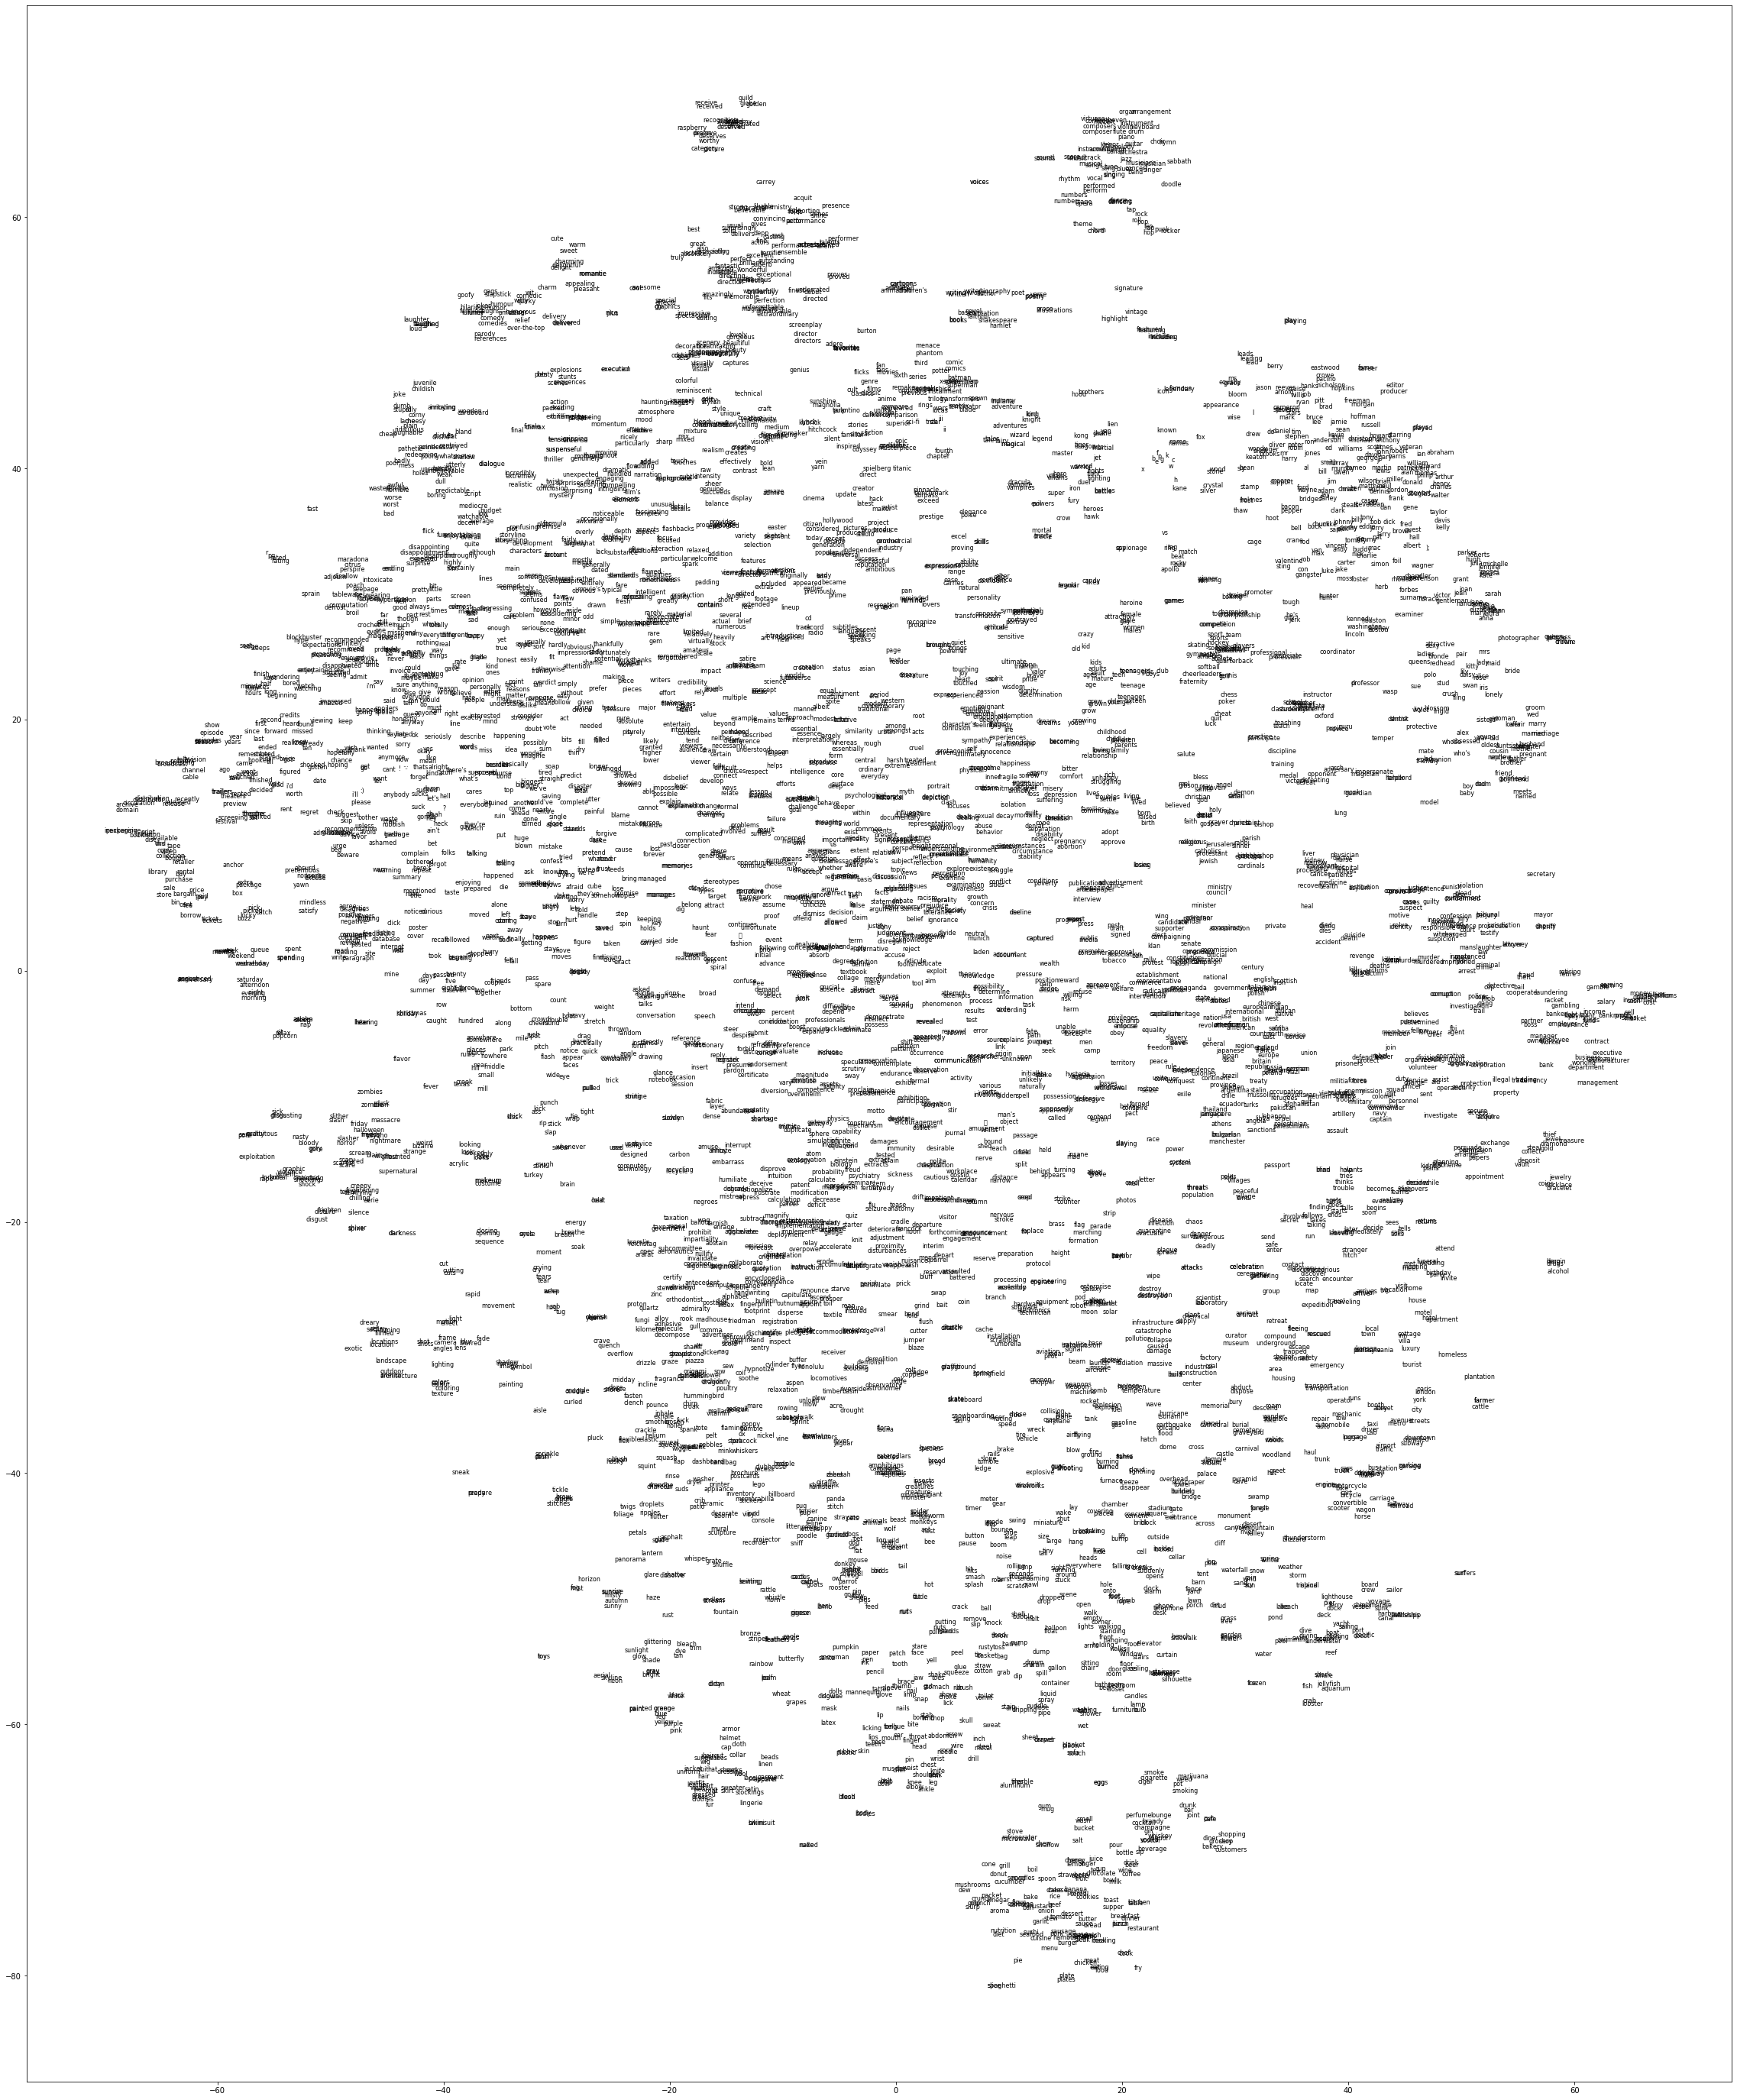

In [262]:
vsm.tsne_viz(imdb20_pmi)

## Exploratory exercises

These are largely meant to give you a feel for the material, but some of them could lead to projects and help you with future work for the course. These are not for credit.

1. Recall that there are two versions each of the IMDB and Gigaword matrices: one with window size 5 and counts scaled as  1/𝑑  where  𝑑  is the distance from the target word; and one with a window size of 20 and no scaling of the values. Using vsm.neighbors to explore, how would you describe the impact of these different designs?

Below "horror"'s neighbors with window size 5 are things that would form syntactic constituents with "horror", like in the noun phrases "horror movie". With window size 20 we see "scares", which is unlikely to occur in a noun phrase with "horror" but is semantically related.

In [276]:
vsm.neighbors('horror', imdb5).head()

horror    0.000000
.         0.884117
movie     0.904059
flicks    0.906300
film      0.913495
dtype: float64

In [277]:
vsm.neighbors('horror', imdb20).head()

horror    0.000000
.         0.185582
scares    0.233877
genre     0.237915
flicks    0.241075
dtype: float64

2. IMDB and Gigaword are very different domains. Using `vsm.neighbors`, can you find cases where the dominant sense of a word is clearly different in the two domains in a way that is reflected by vector-space proximity?


In [339]:
import string
ascii_letters = set(string.ascii_letters)

def neighbors(word, model):
    t = vsm.neighbors(word, model)
    return t[t.index.map(lambda word: len(word) > 3 and not set(word) - ascii_letters)]

def compare(word, imdb, giga):
    print('IMDB:')
    display(neighbors(word, imdb).head())
    print()
    print('Giga:')
    display(neighbors(word, giga).head())
    
compare('star', imdb20, giga20)

IMDB:


star          0.000000
wars          0.077425
trek          0.121685
lucas         0.253259
disappoint    0.267510
dtype: float64


Giga:


star       0.000000
daily      0.184384
kansas     0.187128
seattle    0.191390
houston    0.192153
dtype: float64

3. We saw that euclidean distance favors raw frequencies. Find words in the matrix `imdb20` that help make this point: a pair that are semantically unrelated but close according to `vsm.euclidean`, and a pair that are semantically related by far apart according to `vsm.euclidean`.

Below I find the rank of each word'd similarity to "star". There are a number of very common words that rank in the top 500 similar words by Euclidean distance that are in the bottom 500 by cosine similarity. This appears to just be due to that shared commonness.

In [395]:
good = imdb20.loc['star']
by_euclidean = imdb20.apply(lambda row: vsm.euclidean(good, row), axis=1).sort_values(ascending=False)
by_cosine = imdb20.apply(lambda row: vsm.cosine(good, row), axis=1).sort_values(ascending=False)

df = pd.DataFrame(
    {
        'euclidean': by_euclidean,
        'cosine': by_cosine
    }
)

In [396]:
df['cosine_rank'] = df.cosine.rank()
df['euclidean_rank'] = df.euclidean.rank()

df['difference'] = df.cosine_rank - df.euclidean_rank

df.sort_values('difference', ascending=False).head(20)

,euclidean,cosine,cosine_rank,euclidean_rank,difference
bond,245049.426682,0.358664,4894.0,386.0,4508.0
school,237806.697507,0.343245,4704.0,260.0,4444.0
game,239703.177586,0.343306,4709.0,297.0,4412.0
town,245528.878851,0.348400,4795.0,396.0,4399.0
ago,247772.109577,0.349617,4812.0,430.0,4382.0
,258857.611868,0.429870,4984.0,606.0,4378.0
batman,256057.180960,0.364828,4922.0,557.0,4365.0
son,238102.737977,0.339840,4606.0,265.0,4341.0
season,256300.157284,0.360110,4900.0,560.0,4340.0
car,242524.252377,0.342197,4679.0,351.0,4328.0


4. Run 

  ```amod = pd.read_csv(os.path.join(DATA_HOME, 'gigawordnyt-advmod-matrix.csv.gz'), index_col=0)``` 
  
  to read in an adjective $\times$ adverb matrix derived from the Gigaword corpus. Each cell contains the number of times that the modifier phrase __ADV ADJ__ appeared in Gigaword as given by dependency parses of the data. __ADJ__ is the row value and __ADV__ is the column value. Using the above techniques and measures, try to get a feel for what can be done with this matrix.

In [397]:
amod = pd.read_csv(os.path.join(DATA_HOME, 'gigawordnyt-advmod-matrix.csv.gz'), index_col=0)

In [568]:
# For some reason there are a few (4) columns that have zero sum. This is breaking PMI so
# I'm just dropping them here.
total_zero = amod.sum() == 0
amod = amod.drop(columns=total_zero[total_zero].index)

In [569]:
print(amod.shape)

amod.loc[
    ['pretty', 'beautiful', 'ugly', 'funny', 'sad', 'unbelievable', 'crazy'],
    ['entirely', 'very', 'so', 'conventionally', 'incredibly', ]
]

(3000, 2996)


,entirely,very,so,conventionally,incredibly
Word,,,,,
pretty,1,387,318,14,5
beautiful,0,736,1125,25,110
ugly,0,294,299,0,13
funny,9,1855,901,2,32
sad,4,2070,911,0,66
unbelievable,2,1,113,0,3
crazy,3,25,397,0,1


In [570]:
# Most common adjectives. It's weird that they're not adjectives. It makes sense that some non-adjectives
# would show up because of POS-tagging errors but for "is" to be the top adjective seems really weird.
amod.T.sum().sort_values(ascending=False).head()

Word
is      531048
have    385657
was     349355
much    344110
said    340499
dtype: int64

In [571]:
amod_pmi = vsm.pmi(amod)

In [573]:
amod_pmi.loc[
    ['pretty', 'beautiful', 'ugly', 'funny', 'sad', 'unbelievable', 'crazy'],
    ['entirely', 'very', 'so', 'conventionally', 'incredibly']
]

,entirely,very,so,conventionally,incredibly
Word,,,,,
pretty,0.000000,1.863405,1.143228,5.780874,1.594919
beautiful,0.000000,1.305498,1.206002,5.159980,3.485249
ugly,0.000000,1.625333,1.118393,0.000000,2.587204
funny,0.000000,2.174347,0.928408,2.578690,2.194944
sad,0.000000,2.806271,1.461706,0.000000,3.441123
unbelievable,0.215731,0.000000,0.836783,0.000000,1.812313
crazy,0.000000,0.000000,1.152307,0.000000,0.000000


For a given adjective we can find the adverbs that unexpectedly often co-occur with it.

In [583]:
amod_pmi.loc['strong'].sort_values(ascending=False).head()

unexpectedly     4.355100
steamy           4.346153
exceptionally    3.844396
surprisingly     3.771427
freakishly       3.660728
Name: strong, dtype: float64

Or we can find the other adjectives that are similar to it.

In [584]:
vsm.neighbors('strong', amod_pmi).head()

Word
strong    0.000000
sharp     0.598099
robust    0.603179
large     0.604783
weak      0.617587
dtype: float64

In [587]:
vsm.neighbors('democratically', amod_pmi.T).head(10)

democratically      0.000000
popularly           0.815836
unanimously         0.820662
congressionally     0.825468
newly               0.832229
locally             0.832316
mystically          0.833006
freely              0.836969
constitutionally    0.839051
fully               0.839364
dtype: float64

In [588]:
amod_pmi['democratically'].sort_values(ascending=False).head(10)

Word
elected        7.593807
oriented       4.612104
chosen         4.515741
accountable    4.406053
inclined       4.317339
enacted        3.532861
express        3.257062
controlled     3.250935
entrenched     3.051593
selected       2.968498
Name: democratically, dtype: float64

1. [Turney and Pantel (2010)](http://www.jair.org/media/2934/live-2934-4846-jair.pdf), p. 158, propose a "contextual discounting" extension of PMI to try to address its bias for low-frequency events. Extend `vsm.pmi` so that the user has the option of performing this discounting with the keyword argument `discounting=True`.

In [589]:
def pmi(df, positive=True, discounting=True):
    df = observed_over_expected(df)
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [605]:
normer = amod / (amod+1)

In [608]:
top = np.outer(amod.min(axis=0), amod.min(axis=1))
bottom = top / (top+1)
second_normer = top / bottom

/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [606]:
amod_pmi.shape

(3000, 2996)

In [607]:
normer.shape

(3000, 2996)

One-off compute the contextually weighted PMI for `('very', 'funny')`.

In [632]:
def normed_pmi(adjective, adverb):
    a = amod_pmi.loc[adjective, adverb]
    
    b = amod.loc[adjective, adverb] / (amod.loc[adjective, adverb] + 1)
    
    sum_adj = amod.loc[adjective].sum()
    sum_adv = amod.loc[:, adverb].sum()
    c = min(sum_adj, sum_adv)
    
    return a * b * (c / (c+1))

In [633]:
normed_pmi('funny', 'very')

2.173006213593013

In [635]:
amod_pmi.loc['are', 'cents'], normed_pmi('are', 'cents')

(0.3467826943854031, 0.17107946256346554)

Note that I could create a admod_normed_pmi matrix too and then look at (a) how correlated it is with amod_pmi and (b) the head and the tail of their rank comparisons.